### Setup and Helper Functions

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt

FILEPATH = "/Users/IKleisle/Downloads/"
FILENAME = "simplified-sfo-weather (1).csv"

# features, as instructed by problem
FEATURE_COLS = ["intercept", "x1", "x2"]
# target column
TARG_COL = "precip"
# significant digits to print and round with (for testing)
SIG_DIGITS = 8
# load data
data_df = pd.read_csv(FILEPATH+FILENAME)

def process_data(data_df):
    """
    Performs feature engineering, as instructed by problem. 
    """
    data_copy = data_df.copy()

    data_copy["intercept"] = np.ones(data_copy.shape[0])
    data_copy["x1"] = np.sin(
        (2 * np.pi / 365) * (data_copy["day"].values - 1)
    )
    data_copy["x2"] = np.cos(
        (2 * np.pi / 365) * (data_copy["day"].values - 1)
    )
    return data_copy

def slice_data_by_year(
    data_df, 
    year, 
    feature_cols=FEATURE_COLS, 
    targ_col=TARG_COL,
):
    """
    Partitions training/validation data by year.
    """
    # setup
    data_copy = data_df.copy()
    year = str(year)
    # partition on years
    data_train = data_copy.query(f"year < {year}")
    data_new = data_copy.query(f"year == {year}")
    
    X = data_train[feature_cols].values
    Y = data_train[targ_col].values
    Z = data_new[feature_cols].values
    Y_new = data_new[targ_col].values
    return X, Y, Z, Y_new

# computes linear regression
solve_ols = lambda x, y: np.linalg.inv(x.T @ x) @ x.T @ y

def do_spectral(X, Z, Y_new, test=False, test_digits=SIG_DIGITS):
    """
    Computes VDV^T = (I + Z(X'X)^{-1}Z'), and returns V, D
    """
    # I + Z(X'X)^{-1}Z'
    eps_hat_cov = np.eye(len(Y_new)) + Z @ (np.linalg.inv(X.T @ X)) @ Z.T
    # eigenvectors/values
    d, V = np.linalg.eigh(eps_hat_cov)
    # diagonalize eigenvalues
    D = np.diag(d)
    # test, if desired: VDV' == I + Z(X'X)^{-1}Z'
    if test:
        assert np.mean(
            np.round((V @ D @ V.T), test_digits)
            == 
            np.round(eps_hat_cov, test_digits)
        ) == 1.
    return V, D, eps_hat_cov

def solve_m(X, Z, Y_new, test=False, test_digits=SIG_DIGITS):
    """
    Solves M, per problem 1.3
    """
    # perform spectral decomposition
    V, D, eps_hat_cov = do_spectral(
        X, 
        Z, 
        Y_new, 
        test=test, 
        test_digits=test_digits,
    )
    # compute M off of this spectral decomposition
    M = V @ np.diag(np.power(np.diag(D), -1/2)) @ V.T
    # test if desired: M(I + Z(X'X)^{-1}Z')M' == I
    if test:
        assert np.mean(
            np.round(M @ eps_hat_cov @ M.T, test_digits)
            == 
            np.round(np.eye(M.shape[0]), test_digits)
        ) == 1.
    return M

def compute_a_statistic(X, Y, Z, Y_new, **kwargs):
    """
    Computes A, as instructed by problem 1.3
    """
    # solve coefficients
    beta_hat = solve_ols(X, Y)
    # solve M
    M = solve_m(X, Z, Y_new, **kwargs)
    # compute M(Yn - \hat Yn)
    m_yn_ynhat = M @ (Y_new - Z @ beta_hat)
    # numerator of A
    statistic_num = m_yn_ynhat.T @ m_yn_ynhat / len(Y_new)
    # compute Y - Yhat
    y_yhat = Y - X @ beta_hat
    # denominator of A
    statistic_denom = (y_yhat.T @ y_yhat) / (len(Y) - X.shape[1])
    # final statistic: A
    return statistic_num / statistic_denom
    
def compute_p_value(X, Y, Z, Y_new, **kwargs):
    """
    Computes p-value based on A (F-test), as instructed by problem 1.3/1.4. 
    Specifically, H0 of test assumes A ~ F_{n, m-d}
    """
    A = compute_a_statistic(X, Y, Z, Y_new, **kwargs)
    return 1 - f(len(Y_new), len(Y) - X.shape[1]).cdf(A), A

def test_year(data_processed, year, **kwargs):
    """
    Computes a p-value for a particular year.
    """
    # split up data
    X, Y, Z, Y_new = slice_data_by_year(data_processed, year)
    # compute p-value
    pval, stat = compute_p_value(X, Y, Z, Y_new, **kwargs)
    return pval, stat
    


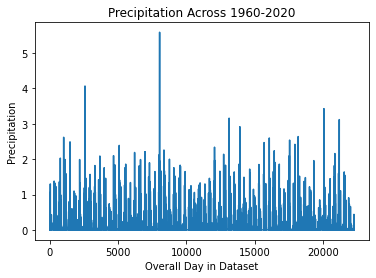

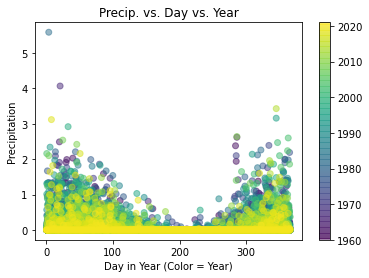

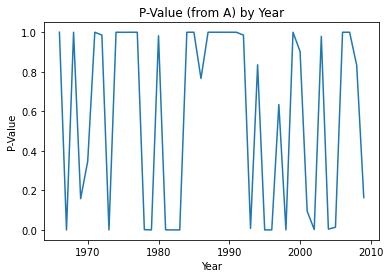

,year,p_value,statistic
0,1966,1.000000,0.626078
1,1967,0.000000,2.244241
2,1968,0.999982,0.711436
3,1969,0.157978,1.078821
4,1970,0.347941,1.029011
5,1971,1.000000,0.323946
6,1972,0.985626,0.840136
7,1973,0.000000,1.719222
8,1974,1.000000,0.556196
9,1975,0.999654,0.762199


In [2]:
# def main():
data_processed = process_data(data_df)
result = [
    (year,) + test_year(data_processed, year, test=True)
     for year in range(1966, 2010)
]

result = pd.DataFrame(result, columns=["year", "p_value", "statistic"]).round(SIG_DIGITS)

plt.plot(data_processed.precip)
plt.xlabel("Overall Day in Dataset")
plt.ylabel("Precipitation")
plt.title("Precipitation Across 1960-2020")
plt.show()

# plot precipitation by year
plt.scatter(data_processed.day, data_processed.precip, c=data_processed.year, alpha=.5)
plt.colorbar()
plt.title("Precip. vs. Day vs. Year")
plt.xlabel("Day in Year (Color = Year)")
plt.ylabel("Precipitation")
plt.show()

# plot p-values by year
plt.plot(result.year, result.p_value)
plt.xlabel("Year")
plt.ylabel("P-Value")
plt.title("P-Value (from A) by Year")
plt.show()


result

For convenience, I've also included (these are the first two plots) precipitation by year and day. 

### c)
Looking at the plot of p-values and the corresponding table, we see that the p-values oscillate wildly from year-to-year, often from extremely low values (what would generally be considered statistically significant) to extremely high values (almost 1!). Of course, this oscillation may simply reflect user error on my part.

At this point, it's probably worth addressing the interpretability of the hypothesis test. Here, we are (1) fitting our model on all previous years $1,\ldots, t-1$. We then (2) set forth our null hypothesis, which is that the model from seasons 1 through $t-1$ will produce OLS coefficients whose transformed/"scaled" (by $M$) residuals in season $t$ be approximately $N(0, \sigma^2)$. A small p-value then suggests that for this single season, the likelihood of seeing that season's transformed residuals under the $N(0, \sigma^2)$ was unlikely, and that another distribution was more appropriate. Conversely, a large p-value would suggest that for this single season, the likelihood of seeing those transformed residuals under the $N(0, \sigma^2)$ was reasonably likely. 

Hence, the oscillation is curious: one season, the residuals follow the null's normal, and the next, they seem to be nothing close to it (before following again shortly). This would seemingly call into question the credibility/reliability of this testing schema, as consecutive validation seasons undermine, only to suddenly reaffirm, faith in the fitted coefficients. 

Lastly, it should be noted that the OLS assumptions -- in particular, the $\epsilon \sim N(0, \sigma^2)$ assumptions -- are dubious. For one, precipitation is only in the non-negative reals, which seemingly violates the (entire) real-valued support of the normal assumption. To this end, given the amount of zero-precipitation days in the dataset (see plots above), the density of precipitation (even within seasons) will be truncated around zero with substantial right tail, in further violation of the normality assumption. Perhaps some sort of data transformation is necessary to better meet this normality assumption. 

### e.)
Certainly, the scenario proposed here is possible: we have a OLS/Normal model (our null hypothesis for the upcoming year) fit on historical data, and the residuals for the new year of data are highly improbable under that null, as given by the small p-value. If the distribution is in fact changing over time, this could result in the small p-value given by the problem. 

However, I'd dispute the problem's characterization that the small p-value necessarily implies change over time. For one, a single year of residuals that deviate from the null is probably not enough to imply a broader "change over time." I'd want more years of similar behavior to corroborate. Further, if our modeling assumptions are inappropriate (as I suspect is the case here), we should not expect the coefficients from the "training" data to have as much use/worth for the new data. In reality, precipitation might not be changing much over time, but due to an inadequate model, our null hypothesis about the new residuals would be fundamentally flawed/erroneous from the outset -- thus, the new data (as it is "farther" from the model prediction) would be unlikely under the flawed/erroneous null. In this case, the small p-value should come as no surprise, and not as a result of any precipitation change. So in conclusion: a small p-value could indicate a change over time (though one year's still a little much for me), but it would not *necessarily* do so. 